# Train & Deploy your own TensorFlow code in AWS SageMaker

In [1]:
import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role
import time

### 1. Define a TensorFlow Estimator

In [2]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

hyperparams={'epochs'       : 20,
             'batch-size'   : 32,
             'optimizer'    : 'adam'}

bucket_name = sagemaker_session.default_bucket()
output_path = f's3://{bucket_name}/jobs'
MetricDefinitions = [
            {
            "Name": "train:error",
            "Regex": "Train_error=(.*?);"
        },
             {
            "Name": "validation:error",
            "Regex": "Valid_error=(.*?);"
        }]

In [3]:
tf_estimator = TensorFlow(entry_point = 'unet_from_scratch.py', 
                          role = role,
                          instance_count = 1, 
                          instance_type  = 'ml.m5.xlarge',
                          py_version = 'py37',
                          framework_version = '2.3.1',
                          script_mode = True,
                          output_path = output_path,
                          sagemaker_session = sagemaker.Session(),
                          metric_definitions = MetricDefinitions)

### 2. Train Model

In [4]:
dataset_uri = 's3://vidushiprojects'
job_name=f'tensorflow-single-gpu-{time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())}'

In [5]:
tf_estimator.fit(dataset_uri, job_name = job_name)

2021-06-29 10:24:52 Starting - Starting the training job...
2021-06-29 10:25:16 Starting - Launching requested ML instancesProfilerReport-1624962291: InProgress
......
2021-06-29 10:26:16 Starting - Preparing the instances for training......
2021-06-29 10:27:16 Downloading - Downloading input data.........
2021-06-29 10:28:44 Training - Downloading the training image..2021-06-29 10:28:59.101622: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-06-29 10:28:59.107992: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-06-29 10:28:59.336835: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-06-29 10:29:02,420 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-06-29 10:29:02,427 sagemaker-tra

### 3. Model Deploy

In [6]:
from sagemaker.serializers import CSVSerializer
predictor=tf_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge'    
)

name = predictor.endpoint_name

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

### 4. Pull Prediction Batch

In [7]:
import s3fs
fs = s3fs.S3FileSystem()
import numpy as np
from PIL import Image
path1 = 's3://vidushiprojects/test/original/'
image_dataset = fs.ls(path1)
img = []
for file in image_dataset:
    img.append(file)


X = np.zeros((3,128,128,3), dtype=np.float32)

for file in img:
    index = img.index(file)
    if(index==0):
        continue
    single_img = Image.open(fs.open(file)).convert('RGB')
    single_img = single_img.resize((128,128))
    single_img = np.reshape(single_img,(128,128,3)) 
    single_img = single_img/256.
    X[index-1] = single_img

### 5. Use Deployed Model for Prediction

In [8]:
from sagemaker.predictor import JSONSerializer, JSONDeserializer

data = {"instances": X.tolist()}

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

out = predictor.predict(data)

Text(0.5, 1.0, 'Predicted Masked Image ')

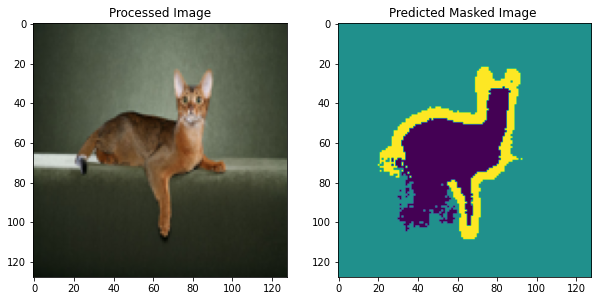

In [9]:
index = 0

import matplotlib.pyplot as plt
pred_mask = np.argmax(out['predictions'][index], axis=-1)
pred_mask = pred_mask[..., np.newaxis]
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(X[index])
arr[0].set_title('Processed Image')
arr[1].imshow(pred_mask[:,:,0])
arr[1].set_title('Predicted Masked Image ')